In [8]:
# CELL 1: imports & global config

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    balanced_accuracy_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    confusion_matrix
)

RANDOM_STATE = 42

plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True

print("Imports complete.")

Imports complete.


In [9]:
# CELL 2: load and clean K9 dataset (local files)

BASE_DIR = "."  # folder where K9 files are located (same as this notebook)

DATA_PATH      = os.path.join(BASE_DIR, "K9.data")
DEF_PATH       = os.path.join(BASE_DIR, "K9.def")
INSTANCE_PATH  = os.path.join(BASE_DIR, "K9.instance.tags")

print("Using file paths:")
print("  DATA_PATH      =", DATA_PATH)
print("  DEF_PATH       =", DEF_PATH)
print("  INSTANCE_PATH  =", INSTANCE_PATH)

# ========= 1. LOAD INSTANCE TAGS =========
try:
    tags = pd.read_csv(
        INSTANCE_PATH,
        header=None,
        names=["ID"]
    )
    # strip leading '%' so IDs match those in K9.def
    tags["ID"] = tags["ID"].astype(str).str.lstrip("%")

    print(f"\nLoaded instance tags: {tags.shape[0]} rows")
    print(tags.head())
except Exception as e:
    raise RuntimeError(f"Error loading instance tags: {e}")

# ========= 2. LOAD FEATURE MATRIX =========
try:
    X_features = pd.read_csv(
        DATA_PATH,
        sep=None,          
        engine="python",
        header=None,
        na_values=["?"]
    )
    print(f"\nLoaded feature matrix (raw): {X_features.shape}")
    print(X_features.head())
except Exception as e:
    raise RuntimeError(f"Error loading feature matrix: {e}")

# Drop non-numeric columns
non_numeric_cols = X_features.select_dtypes(exclude=[np.number]).columns
print("\nNon-numeric columns in K9.data:", list(non_numeric_cols))

if len(non_numeric_cols) > 0:
    X_features = X_features.drop(columns=non_numeric_cols)
    print(f"After dropping non-numeric columns, feature matrix: {X_features.shape}")

# sanity check
if X_features.shape[0] != tags.shape[0]:
    raise ValueError(
        f"Row mismatch: K9.data has {X_features.shape[0]} rows, "
        f"but K9.instance.tags has {tags.shape[0]} rows."
    )

# Rename feature columns
X_features.columns = [f"feat_{i}" for i in range(X_features.shape[1])]

# Attach IDs
X_raw = pd.concat([tags, X_features], axis=1)
print(f"\nFeature matrix with IDs attached: {X_raw.shape}")
print(X_raw.head())

# ========= 3. LOAD LABELS =========
try:
    y_df = pd.read_csv(
        DEF_PATH,
        sep=r"\s+|\t+",
        header=None,
        engine="python",
        names=["ID", "Activity_Status"]
    )
    print(f"\nLoaded label file: {y_df.shape}")
    print(y_df.head())
except Exception as e:
    raise RuntimeError(f"Error loading label file: {e}")

# ========= 4. MERGE FEATURES + LABELS BY ID =========
print("\nAligning features and labels by ID...")

merged = pd.merge(
    X_raw,          # ID + feat_* columns
    y_df,           # ID + Activity_Status
    on="ID",
    how="inner"
)

print(f"Merged table shape (before cleaning): {merged.shape}")

if merged.shape[0] == 0:
    raise ValueError("ERROR: Merge resulted in 0 rows. IDs still do not match across files.")

# Convert active/inactive to 1/0
merged["Target"] = np.where(merged["Activity_Status"] == "active", 1, 0)

feature_cols = [col for col in merged.columns if col.startswith("feat_")]

# ========= 5. DROP USELESS MISSING DATA =========

# 5a. Drop feature columns that are entirely NaN
all_nan_cols = [c for c in feature_cols if merged[c].isna().all()]
if all_nan_cols:
    print("Dropping entirely-NaN feature columns:", all_nan_cols)
    merged = merged.drop(columns=all_nan_cols)
    feature_cols = [col for col in merged.columns if col.startswith("feat_")]

# 5b. Drop rows where all feature values are NaN
row_all_nan = merged[feature_cols].isna().all(axis=1)
num_all_nan_rows = row_all_nan.sum()
if num_all_nan_rows > 0:
    print(f"Dropping {num_all_nan_rows} rows where all feature values are NaN.")
    merged = merged.loc[~row_all_nan].reset_index(drop=True)

print(f"Shape after dropping all-NaN rows/columns: {merged.shape}")

# ========= 6. MERGE COMPLETELY DUPLICATED ROWS =========
before_dedup = merged.shape[0]
merged = merged.drop_duplicates(subset=feature_cols + ["Target"])
after_dedup = merged.shape[0]

print(f"Removed {before_dedup - after_dedup} completely duplicated rows.")
print(f"Shape after deduplicating: {merged.shape}")

# ========= 7. FINAL MATRICES =========
X_full = merged[feature_cols]
y = merged["Target"]

print("\nFinal shapes:")
print("  X_full =", X_full.shape)
print("  y      =", y.shape)

print("\nMissing values per feature (top 5):")
print(X_full.isnull().sum().sort_values(ascending=False).head())


Using file paths:
  DATA_PATH      = .\K9.data
  DEF_PATH       = .\K9.def
  INSTANCE_PATH  = .\K9.instance.tags

Loaded instance tags: 31420 rows
                  ID
0              a119e
1        a119e_l125p
2  a119e_r283k_a353v
3              a161t
4              c135y

Loaded feature matrix (raw): (31420, 5410)
    0      1      2      3      4      5      6      7      8      9     ...  \
0 -0.161 -0.014  0.002 -0.036 -0.033 -0.093  0.025  0.005  0.000 -0.015  ...   
1 -0.158 -0.002 -0.012 -0.025 -0.012 -0.106  0.013  0.005  0.000 -0.002  ...   
2    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
3 -0.169 -0.025 -0.010 -0.041 -0.045 -0.069  0.038  0.014  0.008 -0.014  ...   
4 -0.183 -0.051 -0.023 -0.077 -0.092 -0.015  0.071  0.027  0.020 -0.019  ...   

    5400   5401   5402   5403   5404   5405   5406   5407      5408  5409  
0  0.013  0.021  0.020  0.016 -0.011  0.003  0.010 -0.007  inactive   NaN  
1 -0.008  0.007  0.015 -0.008 -0.011 -0.004  0.013

In [10]:
# CELL 3: train/test split

print("\n--- data splitting time ---")
TEST_SIZE = 0.25  # 25% for testing

X_train, X_test, y_train, y_test = train_test_split(
    X_full,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"train/test split complete. train size: {len(X_train)}, test size: {len(X_test)}")



--- data splitting time ---
train/test split complete. train size: 23457, test size: 7820


In [11]:
# CELL 4: preprocessing pipelines

print("\n--- preprocessing pipelines setup time ---")

# standard imputation + scaling
base_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# PCA pipeline (for SVM and RF)
PCA_TARGET_VARIANCE = 0.90
pca_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=PCA_TARGET_VARIANCE, random_state=RANDOM_STATE))
])

# Fit PCA pipeline
print("\n--- unsupervised insight: PCA dimensionality reduction ---")
pca_pipeline.fit(X_train)
n_components = pca_pipeline['pca'].n_components_
print(f"PCA retained {n_components} components to capture {PCA_TARGET_VARIANCE * 100:.1f}% variance.")


--- preprocessing pipelines setup time ---

--- unsupervised insight: PCA dimensionality reduction ---
PCA retained 558 components to capture 90.0% variance.


In [12]:
# CELL 5: model training

print("\n--- model training (no hyperparameter grid search, to save memory) ---")

models_to_evaluate = {}

# 1) Logistic Regression
lr_pipeline = Pipeline([
    ('preproc', base_pipeline),
    ('clf', LogisticRegression(
        random_state=RANDOM_STATE,
        solver='liblinear',
        penalty='l2',
        C=1.0,
        max_iter=1000
    ))
])

print("\nFitting Logistic Regression...")
lr_pipeline.fit(X_train, y_train)
models_to_evaluate['LogReg_L2'] = lr_pipeline


# 2) SVM (with PCA)
svm_pipeline = Pipeline([
    ('preproc', pca_pipeline),  
    ('clf', SVC(
        probability=True,
        random_state=RANDOM_STATE,
        kernel='rbf',
        C=1.0
    ))
])

print("\nFitting SVM with PCA...")
svm_pipeline.fit(X_train, y_train)
models_to_evaluate['SVM_PCA_rbf'] = svm_pipeline


# 3) Random Forest (with PCA)
rf_pipeline = Pipeline([
    ('preproc', pca_pipeline),
    ('clf', RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_estimators=200,
        max_depth=10,
        n_jobs=-1
    ))
])

print("\nFitting Random Forest with PCA...")
rf_pipeline.fit(X_train, y_train)
models_to_evaluate['RandomForest_PCA'] = rf_pipeline

print("\nModels trained and ready for evaluation:", list(models_to_evaluate.keys()))



--- model training (no hyperparameter grid search, to save memory) ---

Fitting Logistic Regression...

Fitting SVM with PCA...

Fitting Random Forest with PCA...

Models trained and ready for evaluation: ['LogReg_L2', 'SVM_PCA_rbf', 'RandomForest_PCA']


In [13]:
# CELL 6: evaluation on test set

print("\n--- eval on test set and results generator ---")

results_list = []

for name, model in models_to_evaluate.items():
    print(f"\n=== Evaluating {name} ===")
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    auroc = roc_auc_score(y_test, y_proba)
    auprc = average_precision_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    b_acc = balanced_accuracy_score(y_test, y_pred)
    
    results_list.append({
        'Model': name,
        'AUROC': auroc,
        'AUPRC': auprc,
        'F1-Score': f1,
        'Balanced_Accuracy': b_acc
    })
    
    print(f"AUROC:             {auroc:.4f}")
    print(f"Average Precision: {auprc:.4f}")
    print(f"F1-Score:          {f1:.4f}")
    print(f"Balanced Accuracy: {b_acc:.4f}")

final_results_df = pd.DataFrame(results_list).sort_values(by='AUROC', ascending=False)

print("\n--- Table of Final Results ---")
print(final_results_df.round(4))



--- eval on test set and results generator ---

=== Evaluating LogReg_L2 ===
AUROC:             0.9208
Average Precision: 0.3392
F1-Score:          0.4058
Balanced Accuracy: 0.6831

=== Evaluating SVM_PCA_rbf ===
AUROC:             0.9153
Average Precision: 0.3291
F1-Score:          0.2642
Balanced Accuracy: 0.5916

=== Evaluating RandomForest_PCA ===
AUROC:             0.9137
Average Precision: 0.2728
F1-Score:          0.0465
Balanced Accuracy: 0.5129

--- Table of Final Results ---
              Model   AUROC   AUPRC  F1-Score  Balanced_Accuracy
0         LogReg_L2  0.9208  0.3392    0.4058             0.6831
1       SVM_PCA_rbf  0.9153  0.3291    0.2642             0.5916
2  RandomForest_PCA  0.9137  0.2728    0.0465             0.5129


<Figure size 700x500 with 0 Axes>

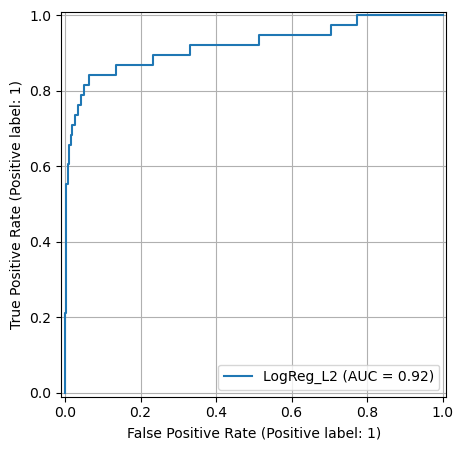

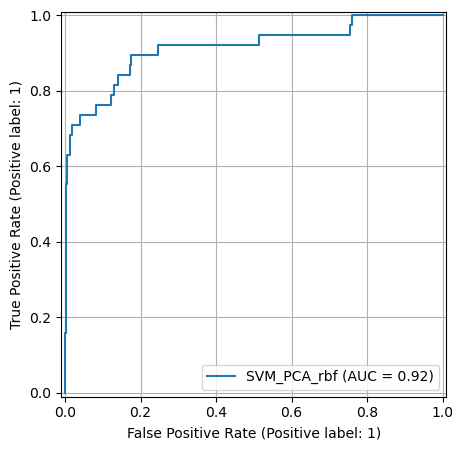

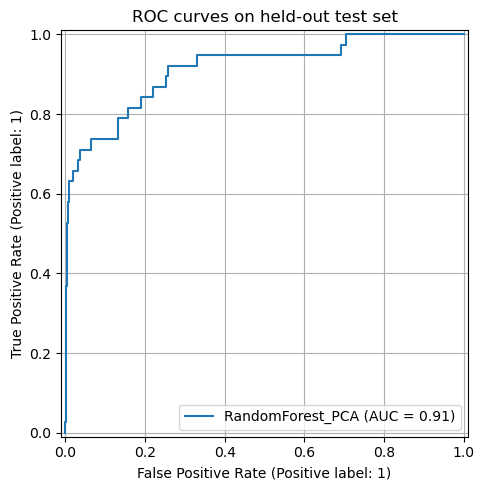

<Figure size 700x500 with 0 Axes>

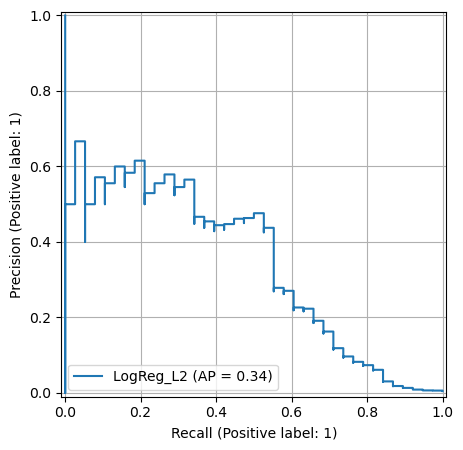

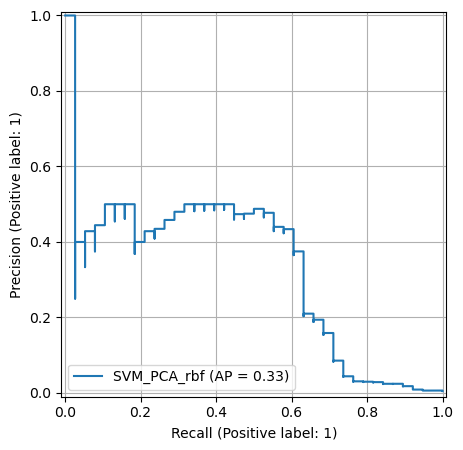

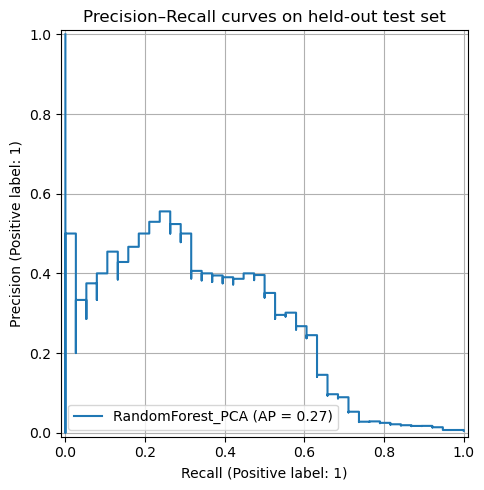

In [14]:
# CELL 7: plots (ROC, PR, PCA)

# ROC curves
plt.figure()
for name, model in models_to_evaluate.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    RocCurveDisplay.from_predictions(
        y_test,
        y_proba,
        name=name
    )
plt.title("ROC curves on held-out test set")
plt.tight_layout()
plt.show()

# Precision–Recall curves
plt.figure()
for name, model in models_to_evaluate.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    PrecisionRecallDisplay.from_predictions(
        y_test,
        y_proba,
        name=name
    )
plt.title("Precision–Recall curves on held-out test set")
plt.tight_layout()
plt.show()